# Analyzing Data Simulation
## Simulation
### Read Text file and make variables

In [6]:
#!/usr/bin/env python3

# read text files

import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import signal, fftpack
from scipy.signal import savgol_filter
%matplotlib inline
#changed 
# - posori kp von 60 auf 100
# - posori2 kp von 35 auf 50
# - joint_task von 33 auf 50
#change
# enter data file here
data_file = "data_Q_12_15_5_R_12_5_QEKF_7_6_7_REKF_12_1"
path = "/Users/elenakern/university/masters/sai-2/apps/inertial_parameter_application/data_collection/hardware/data/"

# path = "/home/elenakern/Codes/sai2.0/applications/data_collection/hardware/data/"
path_data_file = path + data_file

file = np.loadtxt(path_data_file,skiprows=1)

q       = file[0::,0:7]     #joint angles
dq      = file[0::,7:14]    #joint velocities
tau     = file[0::,14:21]   #joint torques commanded
pos_kin     = file[0::,21:24]   #position (end-effector in last link frame)
vel_kin     = file[0::,24:27]   #linear velocity (end-effector in last link frame)
accel_kin   = file[0::,27:30]   #linear acceleration (end-effector in last link frame)
ori_kin     = file[0::,30:34]   #orientation (end-effector in last link frame), quaternion representation
avel_kin    = file[0::,34:37]   #angular velocity (end-effector in last link frame)
aaccel_kin  = file[0::,37:40]   #angular acceleration (end-effector in last link frame)
gravity = file[0::,40:43]   #gravity vector (end-effector in last link frame)

accel_sensor_raw = file[0::,43:46]
avel_sensor_raw = file[0::,46:49]
accel_sensor_corrected = file[0::,49:52]
avel_sensor_corrected = file[0::,52:55]

pos_kf = file[0::,55:58]
vel_kf = file[0::,58:61]
accel_kf = file[0::,61:64]

ori_ekf = file[0::,64:68]
avel_ekf = file[0::,68:71]
aaccel_ekf = file[0::,71:74]



time = np.arange(np.size(q[:,0]))
time = time/1000

### Cross checking with data file

In [7]:
print("q: {}, \nq shape: {}".format(q[0,:], q.shape))
print("dq: {}, \ndq shape: {}".format(dq[0,:], dq.shape))
print("tau: {}, \ntau shape: {}".format(tau[0,:], tau.shape))
print("pos: {}, \npos shape: {}".format(pos[0,:], pos.shape))
print("vel: {}, \nvel shape: {}".format(vel[0,:], vel.shape))
print("accel: {}, \naccel shape: {}".format(accel[0,:], accel.shape))
print("ori: {}, \nori shape: {}".format(ori[0,:], ori.shape))
print("avel: {}, \navel shape: {}".format(avel[0,:], avel.shape))
print("aaccel: {}, \naaccel shape: {}".format(aaccel[0,:], aaccel.shape))
print("gravity: {}, \ngravity shape: {}".format(gravity[0,:], gravity.shape))

q: [ 0.023721  -0.791995   0.0626275 -2.1892     0.134337   1.26965
  0.941985 ], 
q shape: (8805, 7)
dq: [ 0.0700044   0.0645528   0.120995   -0.140982    0.0094242   0.202374
 -0.00027145], 
dq shape: (8805, 7)
tau: [ 0.693175  0.609608  0.969015 -0.601503  0.557915  0.331604  0.375527], 
tau shape: (8805, 7)


NameError: name 'pos' is not defined

## Plotting functions

### TUM colors

In [8]:
#TUM colors rgb
blue = (0,0.3961,0.7412)
red = (0.7686,0.0275,0.1059)
green =(0,0.4863,0.1882)
orange =  (0.8902, 0.4471, 0.1333)
purple = (0.4118, 0.0314, 0.3529)
grey = (0.6118, 0.6157, 0.6235)
yellow = (0.9765, 0.7294, 0)

### Function Definitions

Plot_six_dim(time, data, title, subtitle, savename)
Plot_quaternions(time, quaternions, savename)
- Plots quaternionen
Plot_xyz(time, x, y, z, label_name_x,label_name_y, label_name_z, y_axis_label,title, savename)
- Plots 3 variables (x,y,z)

In [9]:
def Plot_quaternions(time, quaternions, savename):
    w = quaternions[:,0]
    x = quaternions[:,1]
    y = quaternions[:,2]
    z = quaternions[:,3]
    f, axarr = plt.subplots(2,2,figsize=(9,9))
    f.suptitle("Orientation represented as Unit Quaternions" , fontsize=20)
    axarr[0,0].plot(time, w, c=blue)
    axarr[0,0].set_title("$q_w$")
    axarr[0,0].set_xlim([0, time[-1]])
    axarr[0,1].plot(time, x, c=blue)
    axarr[0,1].set_title("$q_x$")
    axarr[0,1].set_xlim([0, time[-1]])
    axarr[1,0].plot(time, y, c=blue)
    axarr[1,0].set_title("$q_y$")
    axarr[1,0].set_xlim([0, time[-1]])
    axarr[1,0].set_xlabel("Elapsed time in s")
    axarr[1,1].plot(time, z, c=blue)
    axarr[1,1].set_title("$q_z$")
    axarr[1,1].set_xlim([0, time[-1]])
    axarr[1,1].set_xlabel("Elapsed time in s")
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
    plt.savefig(savename)

def Plot_seven_dim(time, data, title, subtitle, savename):
    f, axarr = plt.subplots(7,1,figsize=(9,9))
    f.suptitle(title, fontsize=20)
    for i in range(7):
        axarr[i].plot(time, data[:,i], c=blue)
        axarr[i].set_title(subtitle+str( i))
        axarr[i].set_xlim([0, time[-1]])
    axarr[6].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(savename)
    
def Plot_three_dim(time, data, title, subtitle, savename):
    f, axarr = plt.subplots(3,1)
    f.suptitle(title, fontsize=20)
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx,coordinate in enumerate(coordinates):
        axarr[idx].plot(time, data[:,idx], c=blue)
        axarr[idx].set_title(subtitle+str(coordinate))
        axarr[idx].set_xlim([0, time[-1]])
    axarr[2].set_xlabel("Elapsed time in $s$")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(savename)
    


    
def Plot_xyz(time, x, y, z, label_name_x,label_name_y, label_name_z, y_axis_label,title, savename):
	plt.figure(figsize=(9,9))
	plt.plot(time, x, c=blue, label = label_name_x)
	plt.plot(time, y, c=red, label = label_name_y)
	plt.plot(time, z, c=green, label = label_name_z)
	plt.xlabel("Elapsed time in s")
	plt.ylabel(y_axis_label)
	plt.xlim(left=0)
	plt.title(title)
	plt.legend()
	plt.savefig(savename)
    

     
def PlotCompare(counter, time,data1,data2,label_1, label_2, ylabel, title, savename):
    plt.figure(counter, figsize=(8,9))
    plt.title(title)
    plt.subplot(311)
    plt.tight_layout()
    plt.plot(time, data1[:,0], c=blue, label= label_1)
    plt.plot(time, data2[:,0], c=red, label= label_2)
    plt.title("$x$")
    plt.legend()
    plt.xlabel("Elapsed time in $s$")
    plt.ylabel(ylabel)
    plt.subplot(312)
    plt.tight_layout()
    plt.plot(time,data1[:,1], c=blue, label= label_1) 
    plt.plot(time,data1[:,1], c=red, label= label_2)
    plt.ylabel(ylabel)
    plt.title("$y$")
    plt.legend()
    plt.xlabel("Elapsed time in $s$")
    plt.subplot(313)
    plt.tight_layout()
    plt.plot(time,data1[:,2], c=blue, label= label_1)
    plt.plot(time,data1[:,2], c=red, label= label_2)
    plt.ylabel(ylabel)
    plt.xlabel("Elapsed time in $s$")
    plt.title("$z$")
    plt.legend()
    plt.savefig(savename)

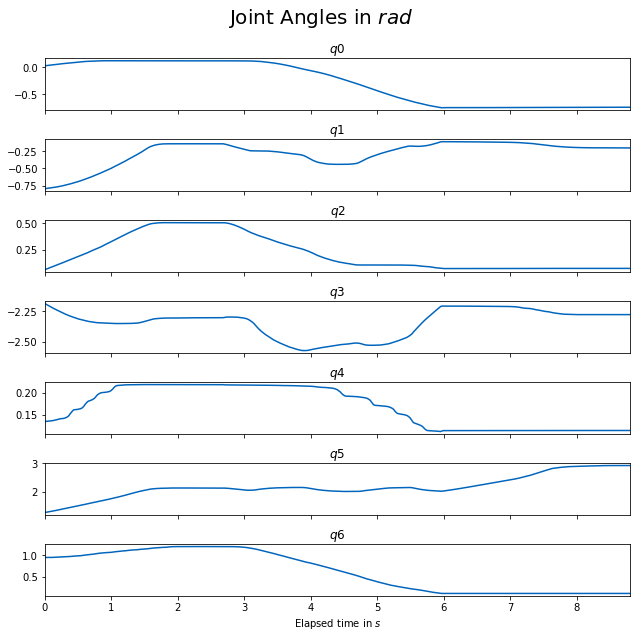

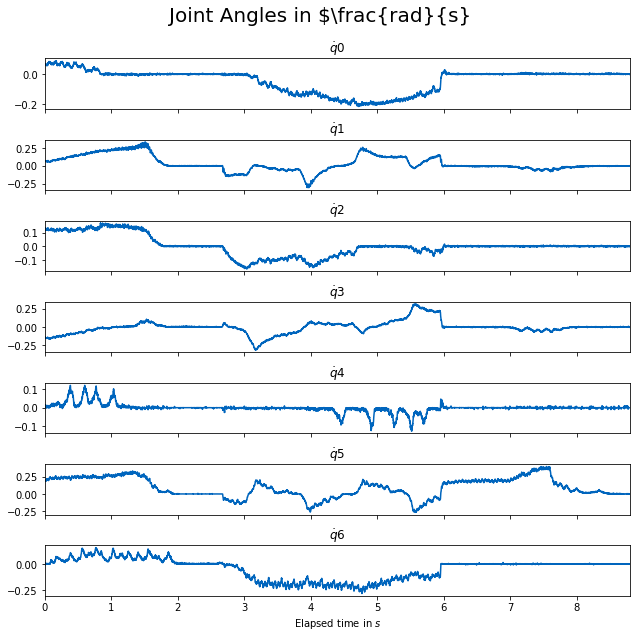

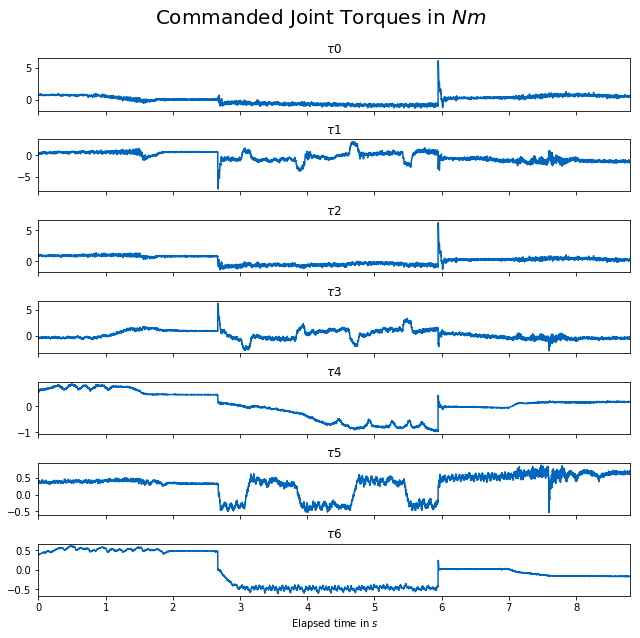

In [10]:
Plot_seven_dim(time, q,"Joint Angles in $rad$", "$q$", "joint_angles_hardware.png")
Plot_seven_dim(time, dq,r"Joint Angles in $\frac{rad}{s}", "$\dot{q}$", "joint_velocities_hardware.png")
Plot_seven_dim(time, tau,"Commanded Joint Torques in $Nm$", r"$\tau$", "joint_velocities_hardware.png")

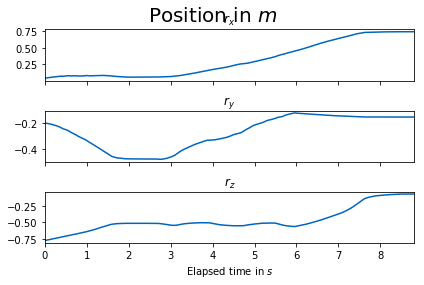

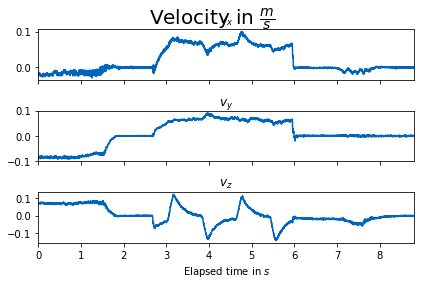

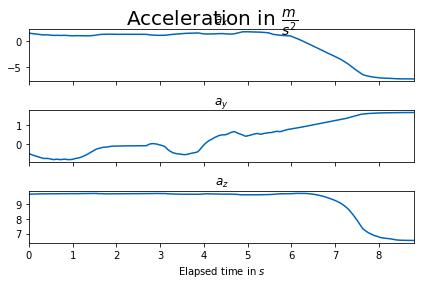

In [11]:
Plot_three_dim(time, pos_kin, "Position in $m$", "$r$", "position.png")
Plot_three_dim(time, vel_kin, r"Velocity in $\frac{m}{s}$", "$v$", "velocity.png")
Plot_three_dim(time, accel_kin, r"Acceleration in $\frac{m}{s^2}$","$a$","acceleration.png")

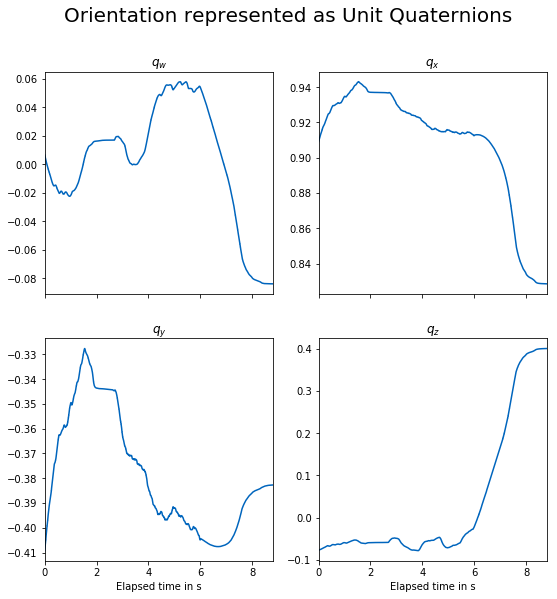

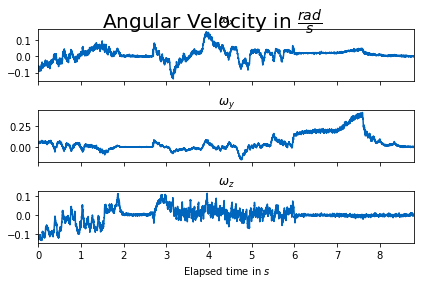

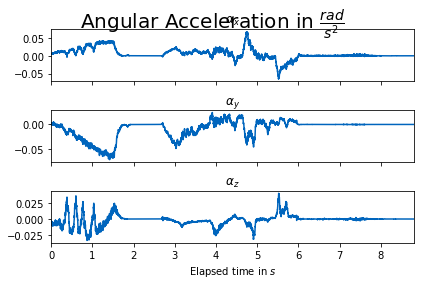

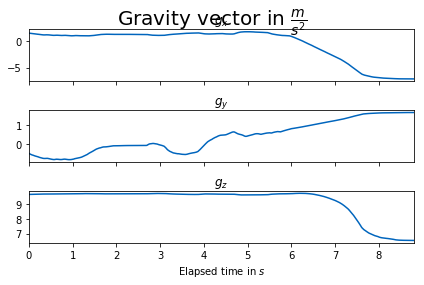

In [12]:
Plot_quaternions(time, ori_kin, "orientation.png")
Plot_three_dim(time, avel_kin, r"Angular Velocity in $\frac{rad}{s}$", "$\omega$", "angular_velocity.png")
Plot_three_dim(time, aaccel_kin, r"Angular Acceleration in $\frac{rad}{s^2}$",r"$\alpha$","angular_acceleration.png")
Plot_three_dim(time, gravity, r"Gravity vector in $\frac{m}{s^2}$","$g$","gravity.png")


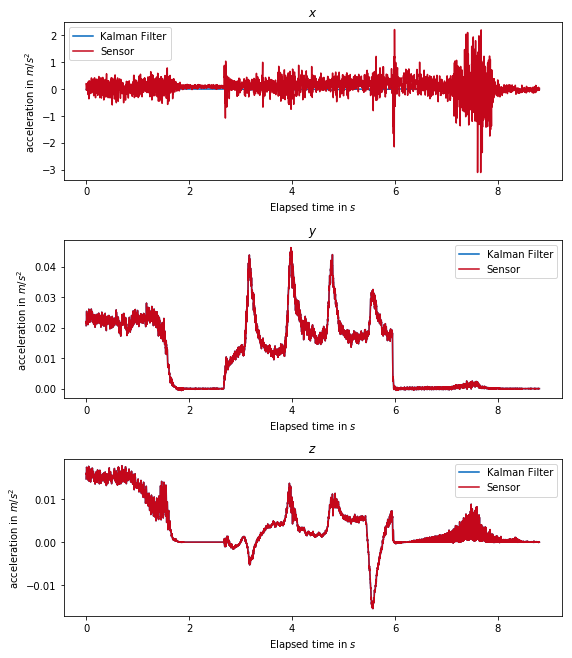

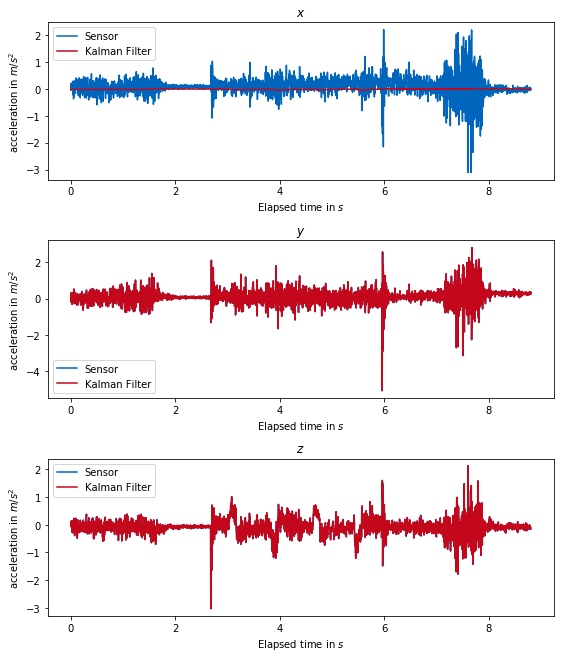

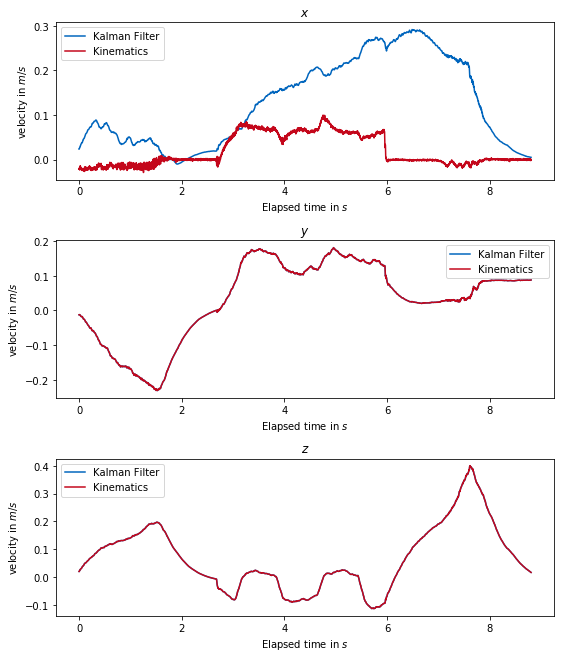

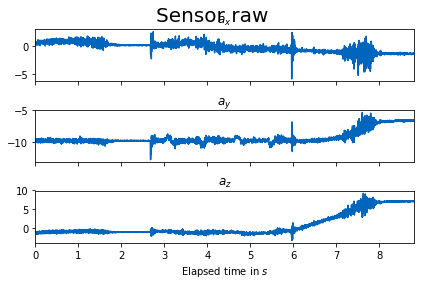

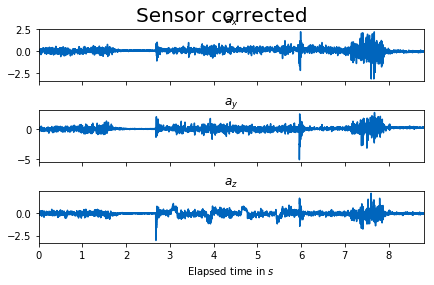

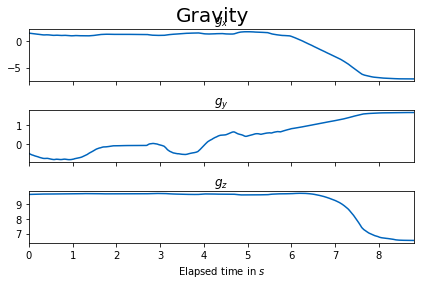

In [13]:
PlotCompare(1, time, accel_kin-gravity, accel_sensor_corrected,"Kalman Filter","Sensor", "acceleration in $m/s^2$","Linear Acceleration Kalman Filter - Kinematics", "compare_kin_sensor.png")
PlotCompare(2, time, accel_sensor_corrected, accel_kin-gravity ,"Sensor", "Kalman Filter" ,"acceleration in $m/s^2$","Linear Acceleration Kalman Filter - Kinematics", "compare_kin_sensor.png")

PlotCompare(3, time, vel_kf,  vel_kin, "Kalman Filter", "Kinematics", "velocity in $m/s$", "Linear Velocity Kalman Filter - Kinematics", "vel_kf_sensor.png")

Plot_three_dim(time, accel_sensor_raw*9.81, r"Sensor raw","$a$","sensor_raw.png")
Plot_three_dim(time, accel_sensor_corrected, r"Sensor corrected","$a$","sensor_corrected.png")
Plot_three_dim(time, gravity, r"Gravity","$g$","gravity.png")




## Filters for smoothing and derivative

In [9]:
avel_gradient =   np.empty_like(avel_sensor_corrected)
avel_savgol =     np.empty_like(avel_sensor_corrected)
avel_dot_savgol = np.empty_like(avel_sensor_corrected)

def filter_signal_SG(data, window_length, polyorder, deriv):
    filtered_data = savgol_filter(data, window_length, polyorder, deriv)
    return filtered_data

for i in range(3):
    avel_gradient[:,i]   = np.gradient(avel_sensor_corrected[:,0])
    avel_savgol[:,i]     = filter_signal_SG(avel_sensor_corrected[:,i],351,7,0)
    avel_dot_savgol[:,i] = filter_signal_SG(avel_sensor_corrected[:,i],351,7,1)

## Total-Variation Regularization Differentiation
### Usage:
### u = TVRegDiff( data, iter, alph, u0, scale, ep, dx, plotflag, diagflag );

In [ ]:
# load file (source: https://github.com/stur86/tvregdiff)
%load_ext autoreload
%autoreload 1
%aimport tvregdiff 

aaccel_tv_1 = np.empty_like(aaccel)
aaccel_tv_2 = np.empty_like(aaccel)
aaccel_tv_3 = np.empty_like(aaccel)
aaccel_tv_4 = np.empty_like(aaccel)
aaccel_tv_5 = np.empty_like(aaccel)

dx = 1/500 #grid spacing is 1/logger_frequency

for i in range(3):
     aaccel_tv_e_1[:,i] = tvregdiff.TVRegDiff(avel[:,i], 5, 1e-1, dx=dx, ep=1e-2, scale='large', plotflag=0)
# for i in range(3):
#      aaccel_tv_e_2[:,i] = tvregdiff.TVRegDiff(avel[:,i], 50, 1e-2, dx=dx, ep=1e-2, scale='large', plotflag=0)
# for i in range(3):
#      aaccel_tv_e_3[:,i] = tvregdiff.TVRegDiff(avel[:,i], 50, 1e-3, dx=dx, ep=1e-2, scale='large', plotflag=0)
# for i in range(3):
#      aaccel_tv_e_4[:,i] = tvregdiff.TVRegDiff(avel[:,i], 50, 1e-4, dx=dx, ep=1e-2, scale='large', plotflag=0)
# for i in range(3):
#      aaccel_tv_e_5[:,i] = tvregdiff.TVRegDiff(avel[:,i], 50, 1e-5, dx=dx, ep=1e-2, scale='large', plotflag=0)


## Plots individually

NameError: name 'PlotNoLimOne' is not defined

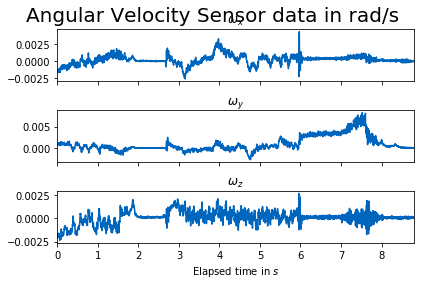

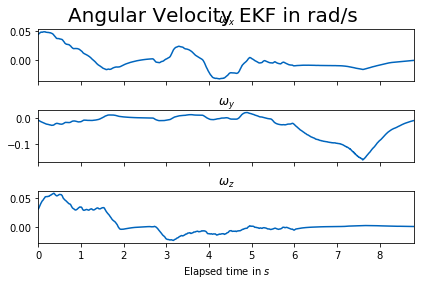

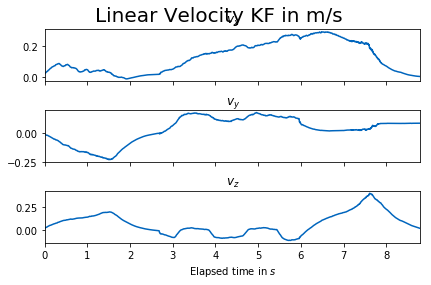

In [14]:
Plot_three_dim(time, avel_sensor_corrected, "Angular Velocity Sensor data in rad/s", "$\omega$", "avel_raw_sensor.png")
Plot_three_dim(time, avel_ekf, "Angular Velocity EKF in rad/s", "$\omega$", "avel_ekf.png")

Plot_three_dim(time, vel_kf, "Linear Velocity KF in m/s", "$v$", "vel_kf.png")
 
PlotNoLimOne(time, avel_hat[:,0],avel_hat[:,1],avel_hat[:,2], "avel_hat_x","avel_hat_y", "avel_hat_z", "Elapsed time in s", "Angular velocity in rad/s", "Angular velocity Extended Kalman filter", "avel_ekf.png")
PlotNoLimOne(time, aaccel_hat[:,0],aaccel_hat[:,1],aaccel_hat[:,2], "aaccel_hat_x","aaccel_hat_y", "aaccel_hat_z", "Elapsed time in s", "Angular acceleration in rad/s^2", "Angular acceleration Extended Kalman filter", "aaccel_ekf.png")
PlotNoLimOne(time, avel_dot_savgol[:,0],avel_dot_savgol[:,1],avel_dot_savgol[:,2], "avel_dot_savgol_x","avel_dot_savgol_y", "avel_dot_savgol_z", "Elapsed time in s", "Angular acceleration in rad/s^2", "Angular acceleration Savitzky Golay", "aaccel_sg.png")


## Plots compare

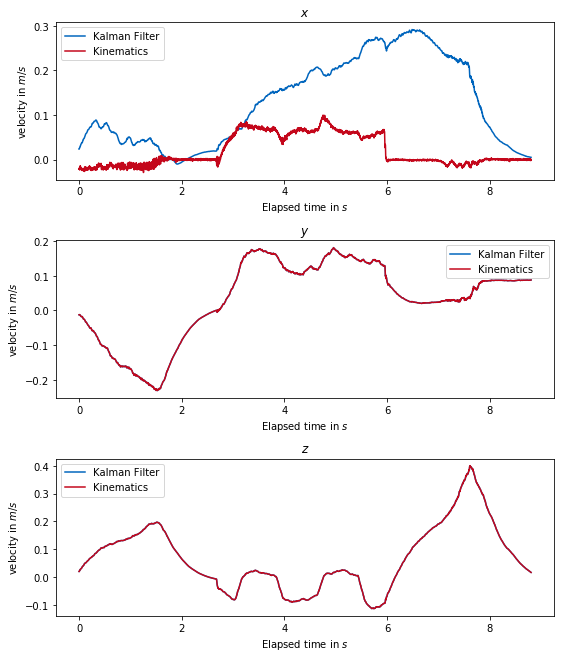

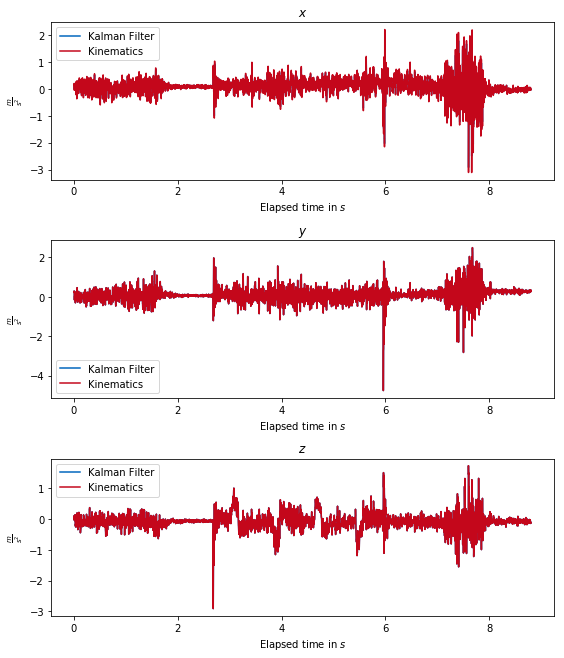

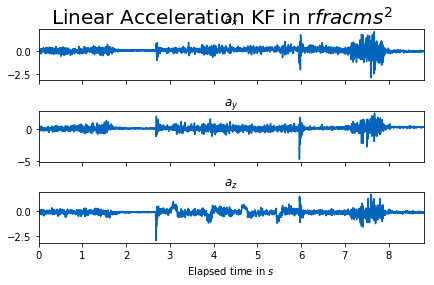

In [15]:
PlotCompare(1, time,vel_kf,vel_kin,"Kalman Filter", "Kinematics", "velocity in $m/s$", "Linear Velocity Kalman Filter - Kinematics", "vel_kf_sensor.png")
PlotCompare(2, time, accel_kf, accel_sensor_corrected,"Kalman Filter","Kinematics", r"$\frac{m}{s^2}$","Linear Acceleration Kalman Filter - Sensor", "accel_kf_sensor.png")
Plot_three_dim(time, accel_kf, "Linear Acceleration KF in r$frac{m}{s^2}$", "$a$", "accel_kf.png")

## Plot Compare SG Filter - np.gradient

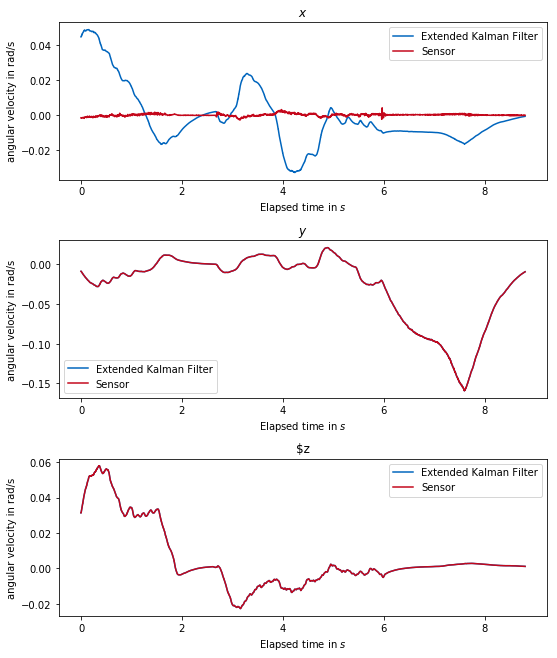

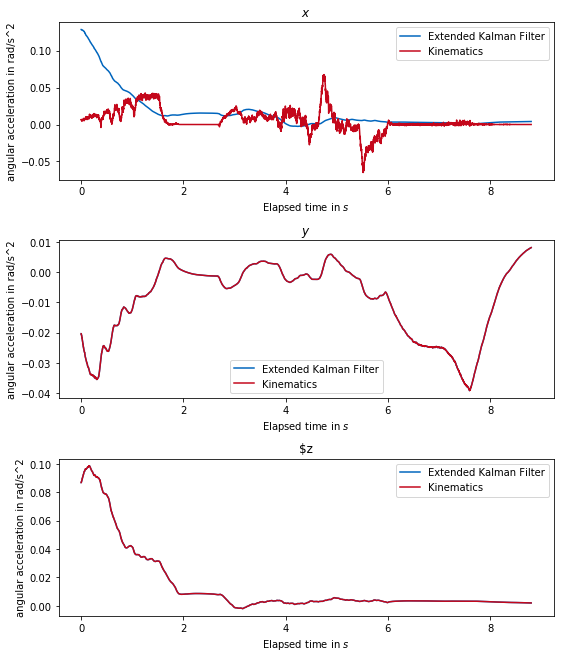

In [29]:
PlotCompare(1, time,avel_ekf,avel_sensor_corrected,"Extended Kalman Filter", "Sensor", "angular velocity in rad/s", "Angular Velocity Extended Kalman Filter - Sensor", "avel_ekf_sensor.png")
PlotCompare(2, time, aaccel_ekf, aaccel_kin,"Extended Kalman Filter","Kinematics", "angular acceleration in rad/s^2","Angular Acceleration Extended Kalman Filter - Kinematics", "aaccel_ekf_sensor.png")

In [ ]:
!pip3 freeze | grep jupyter

In [ ]:
np.arange(6).reshape((3, 2))